# Análise Comparativa de Modelos

## Bibliotecas

In [13]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

In [37]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

from utils.date import get_season
from utils.evaluation import evaluate_model

## Leitura dos dados

In [15]:
df_raw = pd.read_csv('../data/data.csv')
df = df_raw.copy()

## Pré-processamento

In [ ]:
use_log_transform = False

In [17]:
df['dteday'] = pd.to_datetime(df['dteday'])

# preenchendo dia da semana e mês com base na data
df['weekday'] = df['dteday'].dt.dayofweek
df['mnth'] = df['dteday'].dt.month

# em season, preenche apenas as linhas que possue valores nulos
df.loc[df['season'].isnull(), 'season'] = df.loc[df['season'].isnull(), 'dteday'].apply(get_season)

cols_to_drop = ['instant', 'dteday', 'atemp', 'casual', 'registered']
df.drop(columns=cols_to_drop, inplace=True)
df.dropna(inplace=True)

# Transformação das variáveis cíclicas usando seno e cosseno para preservar a periodicidade.
# Isso faz com que valores próximos (tipo 23:00 e 00:00) tenham representações numéricas próximas
df['hr_sin'] = np.sin(2 * np.pi * df['hr'] / 24)
df['hr_cos'] = np.cos(2 * np.pi * df['hr'] / 24)
df['mnth_sin'] = np.sin(2 * np.pi * df['mnth'] / 12)
df['mnth_cos'] = np.cos(2 * np.pi * df['mnth'] / 12)

# removendo as colunas originais que agora são redundantes
df.drop(columns=['hr', 'mnth'], inplace=True)

# transformando variáveis categóricas
categorical_features = ['season', 'weekday', 'weathersit']
df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

## Divisão dos dados

In [18]:
# Dividindo em treino e teste com base no tempo
df_train = df[df['yr'] == 0]
df_test = df[df['yr'] == 1]

df_train = df_train.drop('yr', axis=1)
df_test = df_test.drop('yr', axis=1)

X_train = df_train.drop('cnt', axis=1)
y_train = df_train['cnt']

X_test = df_test.drop('cnt', axis=1)
y_test = df_test['cnt']

print(f"Formato de X_train: {X_train.shape}")
print(f"Formato de y_train: {y_train.shape}")
print(f"Formato de X_test:  {X_test.shape}")
print(f"Formato de y_test:  {y_test.shape}")

Formato de X_train: (6676, 21)
Formato de y_train: (6676,)
Formato de X_test:  (6779, 21)
Formato de y_test:  (6779,)


In [19]:
tscv = TimeSeriesSplit(n_splits=5)

fold_counter = 1
for train_indices, val_indices in tscv.split(X_train):
    print(f"\nFold {fold_counter}:")
    print(f"  - Dados de Treino:   índices de {train_indices.min()} a {train_indices.max()} (Tamanho: {len(train_indices)})")
    print(f"  - Dados de Validação: índices de {val_indices.min()} a {val_indices.max()} (Tamanho: {len(val_indices)})")
    fold_counter += 1


Fold 1:
  - Dados de Treino:   índices de 0 a 1115 (Tamanho: 1116)
  - Dados de Validação: índices de 1116 a 2227 (Tamanho: 1112)

Fold 2:
  - Dados de Treino:   índices de 0 a 2227 (Tamanho: 2228)
  - Dados de Validação: índices de 2228 a 3339 (Tamanho: 1112)

Fold 3:
  - Dados de Treino:   índices de 0 a 3339 (Tamanho: 3340)
  - Dados de Validação: índices de 3340 a 4451 (Tamanho: 1112)

Fold 4:
  - Dados de Treino:   índices de 0 a 4451 (Tamanho: 4452)
  - Dados de Validação: índices de 4452 a 5563 (Tamanho: 1112)

Fold 5:
  - Dados de Treino:   índices de 0 a 5563 (Tamanho: 5564)
  - Dados de Validação: índices de 5564 a 6675 (Tamanho: 1112)


## Modelagem

Para este case, serão testados três modelos: Ridge, RandomForest e LightGBM. Por conta de que a variável alvo é assimétrica, testaremos com e sem a transformação dessa variável

In [20]:
if use_log_transform:
    y_train_target = np.log1p(y_train)
else:
    y_train_target = y_train

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [21]:
models = {
    "Ridge": Ridge(random_state=42),
    "RandomForest": RandomForestRegressor(random_state=42, n_jobs=-1),
    "LightGBM": lgb.LGBMRegressor(random_state=42, n_jobs=-1, force_row_wise=True)
}
results = {}

for name, model in models.items():
    print(f"\n>>> Treinando o modelo: {name}...")

    if name == "Ridge":
        model.fit(X_train_scaled, y_train_target)
        predictions = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train_target)
        predictions = model.predict(X_test)

    if use_log_transform:
        final_predictions = np.expm1(predictions)
    else:
        final_predictions = predictions

    metrics = evaluate_model(y_test, final_predictions, model_name=name)
    results[name] = metrics


>>> Treinando o modelo: Ridge...
--- Desempenho do Ridge ---
RMSE (Root Mean Squared Error):       191.59
RMSLE (Root Mean Squared Log Error): 1.0091
R² (Coeficiente de Determinação):    0.1489
MAE (Mean Absolute Error):           127.43 aluguéis
----------------------------------------

>>> Treinando o modelo: RandomForest...
--- Desempenho do RandomForest ---
RMSE (Root Mean Squared Error):       131.53
RMSLE (Root Mean Squared Log Error): 0.5781
R² (Coeficiente de Determinação):    0.5989
MAE (Mean Absolute Error):           93.18 aluguéis
----------------------------------------

>>> Treinando o modelo: LightGBM...
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 6676, number of used features: 20
[LightGBM] [Info] Start training from score 4.335085
--- Desempenho do LightGBM ---
RMSE (Root Mean Squared Error):       130.67
RMSLE (Root Mean Squared Log Error): 0.5724
R² (Coeficiente de Determinação):    0.6041
MAE (Mean Absolute Error):    

In [22]:
results_df = pd.DataFrame(results).T.sort_values(by='rmsle')
print("\n\nTabela Comparativa de Desempenho Final:")
print(results_df)



Tabela Comparativa de Desempenho Final:
                 rmsle        rmse        r2         mae
LightGBM      0.572419  130.666654  0.604134   93.108522
RandomForest  0.578055  131.529248  0.598890   93.181924
Ridge         1.009141  191.589806  0.148934  127.426150


Resultado com `use_log_transform`=FALSE:

| Modelo       | RMSLE    | RMSE      | R²       | MAE        |
|--------------|----------|-----------|----------|------------|
| RandomForest | 0.536544 | 125.561987| 0.634460 | 88.987089  |
| LightGBM     | 0.641617 | 124.805749| 0.638850 | 89.861922  |
| Ridge        | 1.209710 | 180.355769| 0.245814 | 116.047242 |

Resultado com `use_log_transform`=TRUE:

| Modelo       | RMSLE    | RMSE      | R²       | MAE        |
|--------------|----------|-----------|----------|------------|
| LightGBM     | 0.572419 | 130.666654| 0.604134 | 93.108522  |
| RandomForest | 0.578055 | 131.529248| 0.598890 | 93.181924  |
| Ridge        | 1.009141 | 191.589806| 0.148934 | 127.426150 |

Em ambos os casos, temos o `Ridge` com um desempenho muito fraco (R^2 < 0.25), mostrando que um modelo linear simples não consegue capturar a complexidade do problema.

No cenário 1 o `RandomForest` se saiu melhor, obtendo um RMSLE de 0.53 e um R^2 de 0.63. O `LightGBM` teve resultados semelhantes, porém no RMSLE foi um pouco mais elevado.

No cenário 2 o `LightGBM` melhorou significativamente, sendo o melhor dos três modelos, porém em ambas as métricas RMSE, MAE, R^2, os resultados foram inferiores aos modelos sem aplicar o log na variável alvo.

## Otimização

In [25]:
tuned_results = {}

In [ ]:
# Otimizando o Random Forest sem o log1p
rf_param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None, 0.5]
}

rf_random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    param_distributions=rf_param_dist,
    n_iter=50,
    cv=tscv,
    scoring='neg_mean_squared_log_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Executando a busca (pode levar alguns minutos)
print("Iniciando a busca por parâmetros para o RandomForest...")
rf_random_search.fit(X_train, y_train)

# Apresentando os melhores parâmetros encontrados
print("\nMelhores parâmetros para o RandomForest:", rf_random_search.best_params_)

Iniciando a busca por parâmetros para o RandomForest...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Melhores parâmetros para o RandomForest: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 20}


In [28]:
# Avaliando o melhor modelo encontrado no conjunto de teste
best_rf = rf_random_search.best_estimator_
rf_predictions_tuned = best_rf.predict(X_test)
tuned_results['RandomForest_Tuned'] = evaluate_model(y_test, rf_predictions_tuned, 'RandomForest Otimizado')

--- Desempenho do RandomForest Otimizado ---
RMSE (Root Mean Squared Error):       125.45
RMSLE (Root Mean Squared Log Error): 0.5347
R² (Coeficiente de Determinação):    0.6351
MAE (Mean Absolute Error):           89.00 aluguéis
----------------------------------------


In [34]:
# Otimizando o LightGBM com o log1p
y_train_log = np.log1p(y_train)

lgbm_param_dist = {
    'n_estimators': [100, 200, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [20, 31, 40, 50],
    'max_depth': [-1, 10, 20],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}

# Instanciando o RandomizedSearchCV
lgbm_random_search = RandomizedSearchCV(
    estimator=lgb.LGBMRegressor(random_state=42, n_jobs=-1, force_row_wise=True),
    param_distributions=lgbm_param_dist,
    n_iter=50,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

print("\nIniciando a busca por parâmetros para o LightGBM...")
lgbm_random_search.fit(X_train, y_train_log)

print("\nMelhores parâmetros para o LightGBM:", lgbm_random_search.best_params_)


Iniciando a busca por parâmetros para o LightGBM...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 6676, number of used features: 20
[LightGBM] [Info] Start training from score 4.335085

Melhores parâmetros para o LightGBM: {'reg_lambda': 0.1, 'reg_alpha': 0.1, 'num_leaves': 20, 'n_estimators': 200, 'max_depth': -1, 'learning_rate': 0.1}


In [35]:
# Avaliando o melhor modelo encontrado no conjunto de teste
best_lgbm = lgbm_random_search.best_estimator_
lgbm_log_predictions_tuned = best_lgbm.predict(X_test)
lgbm_predictions_tuned = np.expm1(lgbm_log_predictions_tuned)
tuned_results['LightGBM_Tuned'] = evaluate_model(y_test, lgbm_predictions_tuned, 'LightGBM Otimizado')

--- Desempenho do LightGBM Otimizado ---
RMSE (Root Mean Squared Error):       130.14
RMSLE (Root Mean Squared Log Error): 0.5744
R² (Coeficiente de Determinação):    0.6073
MAE (Mean Absolute Error):           93.02 aluguéis
----------------------------------------


In [ ]:
tuned_results_df = pd.DataFrame(tuned_results).T

print("\nTabela de Desempenho dos Modelos Otimizados:")
print(tuned_results_df.sort_values(by='rmsle'))


Tabela de Desempenho dos Modelos Otimizados:
                      rmsle       rmse        r2        mae
RandomForest_Tuned  0.53468  125.44649  0.635132  88.999211
LightGBM_Tuned      0.57444  130.13581  0.607344  93.019876


### Análise

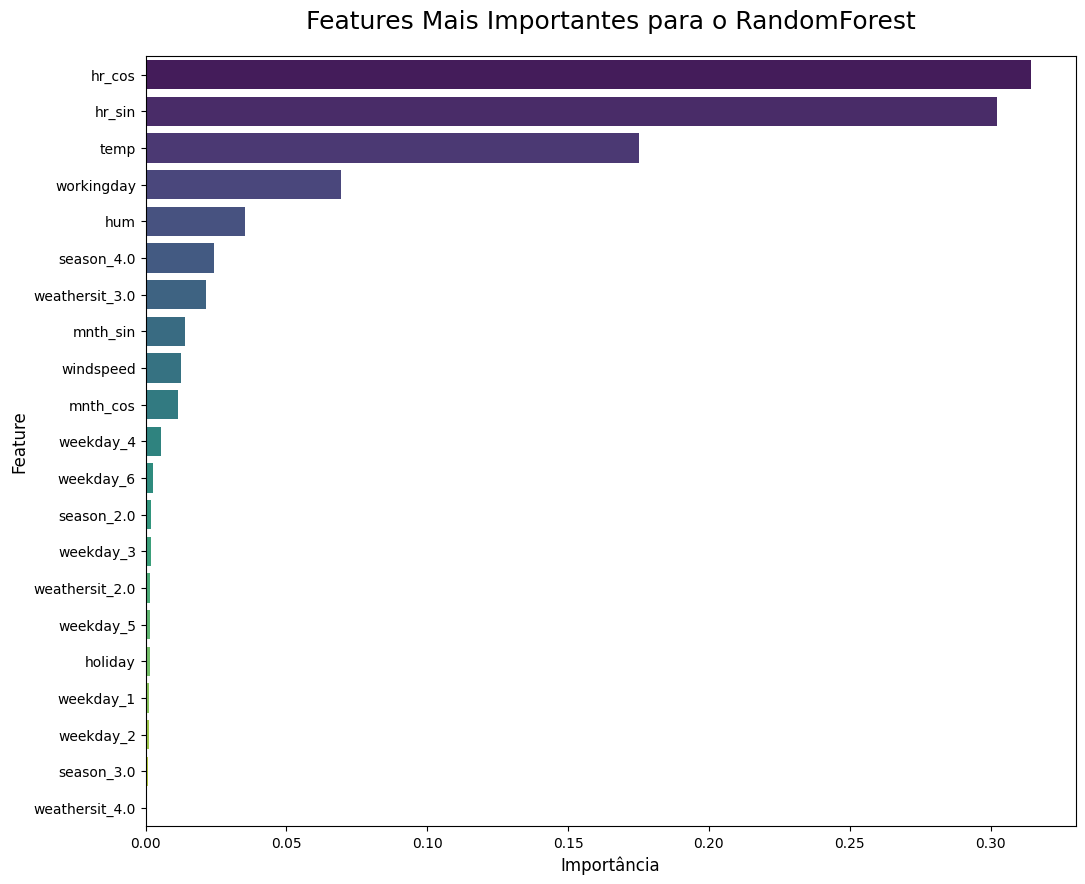

In [ ]:
feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(
    x='importance',
    y='feature',
    data=feature_importance_df,
    palette='viridis',
    hue='feature'
)
plt.title('Features Mais Importantes para o RandomForest', fontsize=18, pad=20)
plt.xlabel('Importância', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()

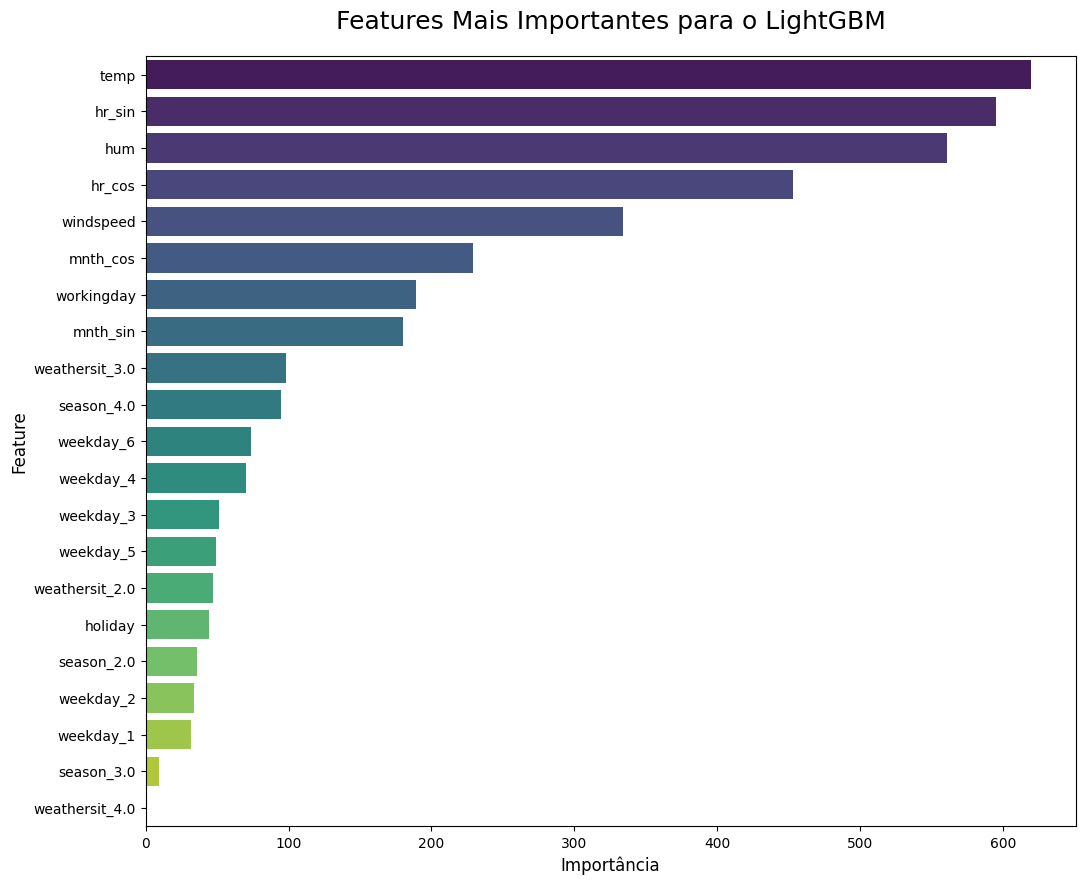

In [51]:
feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_lgbm.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(
    x='importance',
    y='feature',
    data=feature_importance_df,
    palette='viridis',
    hue='feature'
)
plt.title('Features Mais Importantes para o LightGBM', fontsize=18, pad=20)
plt.xlabel('Importância', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()

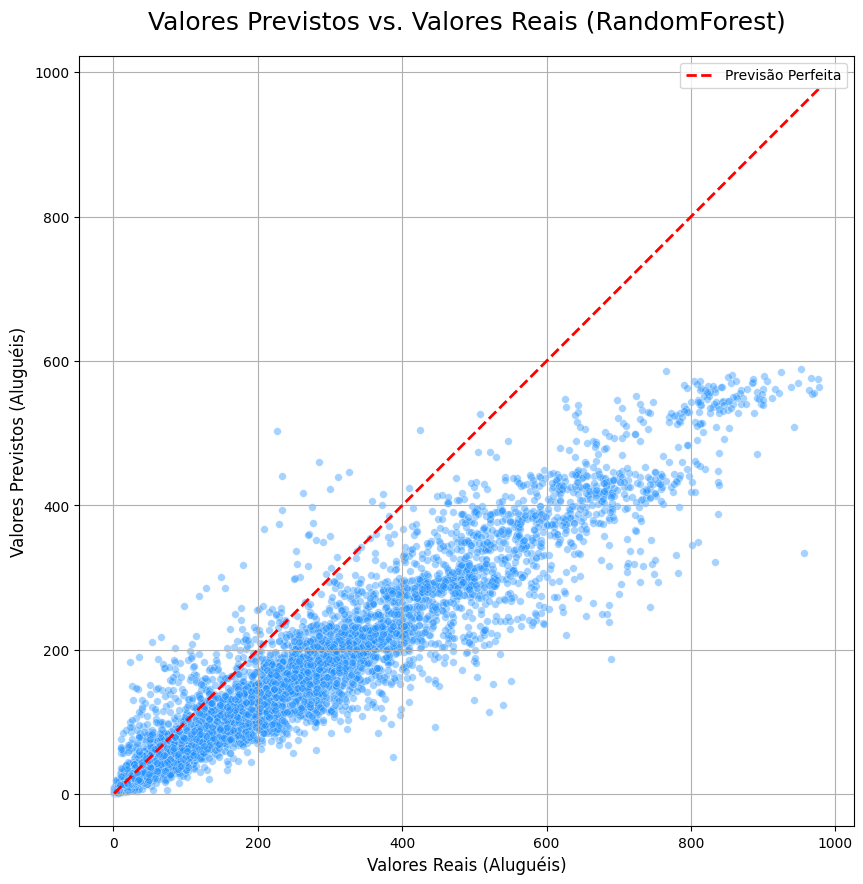

In [44]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x=y_test, y=rf_predictions_tuned, alpha=0.4, s=30, color='dodgerblue')

max_val = max(y_test.max(), rf_predictions_tuned.max())
min_val = min(y_test.min(), rf_predictions_tuned.min())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', lw=2, label='Previsão Perfeita')

plt.title('Valores Previstos vs. Valores Reais (RandomForest)', fontsize=18, pad=20)
plt.xlabel('Valores Reais (Aluguéis)', fontsize=12)
plt.ylabel('Valores Previstos (Aluguéis)', fontsize=12)
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()

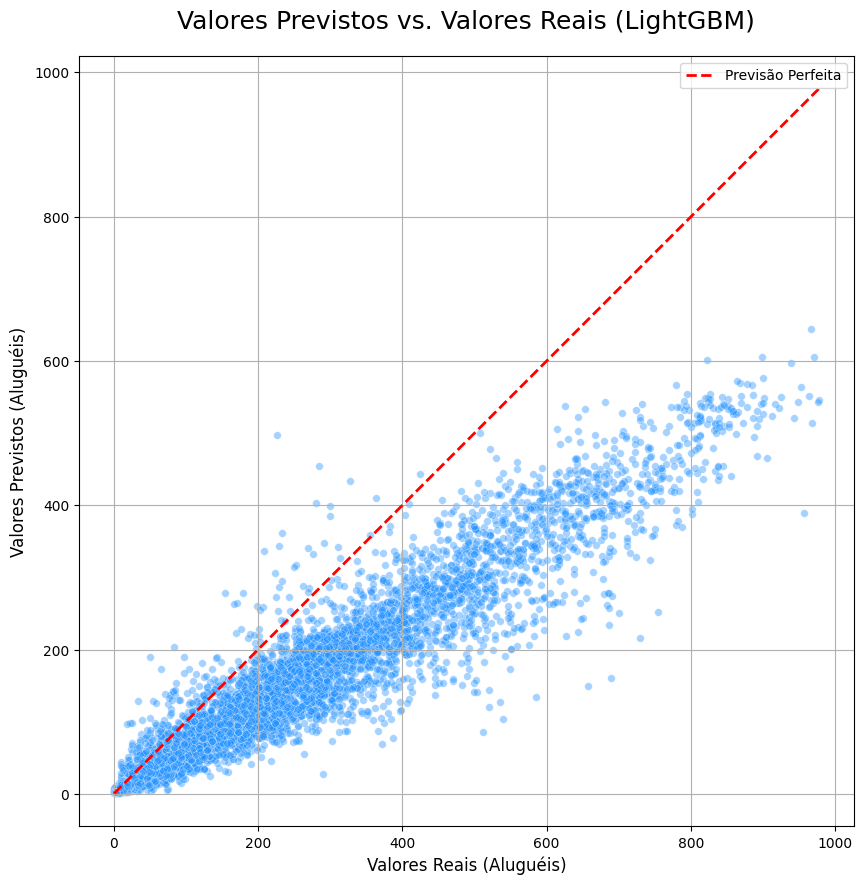

In [45]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x=y_test, y=lgbm_predictions_tuned, alpha=0.4, s=30, color='dodgerblue')

max_val = max(y_test.max(), lgbm_predictions_tuned.max())
min_val = min(y_test.min(), lgbm_predictions_tuned.min())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', lw=2, label='Previsão Perfeita')

plt.title('Valores Previstos vs. Valores Reais (LightGBM)', fontsize=18, pad=20)
plt.xlabel('Valores Reais (Aluguéis)', fontsize=12)
plt.ylabel('Valores Previstos (Aluguéis)', fontsize=12)
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()

Vemos que o gráfico predito vs real para os dois modelos foram bem semelhantes. Ambos conseguiram capturar a tendência geral da demanda, seguindo a trajetória da linha tracejada. Apesar de possuir um desempenho relativamente bom para baixa demanda (abaixo de 200), o modelo tende a piorar quando a demanda é alta (maior que 600). Como foi visto na análise exploratória, esse é o ponto onde a demanda é considerada outlier pelo boxplot.

Apesar de seguir a trajetória, o modelo "hesita" em prever a magnitude total da demanda.

Com a utilização desses modelos no mundo real, com a predição de X aluguéis em um determinado período, a equipe pode saber que há uma alta probabilidade da demanda ser maior que o predito, podendo alocar mais bicicletas do que o modelo sugeriu para garantir que não faltem bicicletas.